# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from German to English.


This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

In [ ]:
# ==== Environment Setup ====
# Detects Colab vs local and provides cross-platform utilities

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running locally")

def download_file(url: str, filename: str) -> str:
    """Download file if it doesn't exist. Works on both Colab and local."""
    if os.path.exists(filename):
        print(f"✓ {filename} already exists")
        return filename
    
    print(f"Downloading {filename}...")
    if IN_COLAB:
        import subprocess
        subprocess.run(['wget', '-q', url, '-O', filename], check=True)
    else:
        import urllib.request
        urllib.request.urlretrieve(url, filename)
    print(f"✓ Downloaded {filename}")
    return filename

In [ ]:
# ==== Device Setup ====
import torch

def get_device():
    """Get best available device: CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple MPS (Metal)")
    else:
        device = torch.device('cpu')
        print("✓ Using CPU")
    return device

DEVICE = get_device()

## Credits

This problem set is based upon an official PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). Many thanks to PyTorch and the orginal author [Sean Robertson](https://github.com/spro/practical-pytorch).

Be cautious with looking in the original notebook for answers. Many details have been changed and you won't be able to copy-and-paste solutions.


## Dependencies

In [ ]:
# Dependencies - uncomment if running on Colab or fresh environment
# Most are pre-installed on Colab; locally use your conda environment
# !pip install torch matplotlib pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 MB 14.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 28.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached pandas-1.5.1-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Using cached numpy-1.23.4-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_10_9_x86_64.whl (65 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.8/240.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.4 MB/s eta 0:00:0031m33.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 9.5 MB/s eta 0:00:00m eta 0:00:01


In [ ]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import time

from IPython.display import Image

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading & preprocessing training data

Each word in a language will be represented as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Language`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [ ]:
SOS_token = 0
EOS_token = 1


class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:

  print("Reading lines...")

  # Read the csv as a dataframe
  import pandas as pd
  df = pd.read_csv(path, encoding='utf-8')

  # Normalize every row (sentence)
  ger_norm = list(df['GER'].apply(normalize_string).values)
  eng_norm = list(df['ENG'].apply(normalize_string).values)

  # Determine translation direction
  if reverse:
      pairs = zip(eng_norm, ger_norm)
  else:
      pairs = zip(ger_norm, eng_norm)

  # if reverse:
  #     pairs = [tuple(reversed(p)) for p in pairs]

  return list(pairs)


Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_WORDS = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)



def filter_pairs(pairs):
    return [pair for pair in pairs if not too_many_words(pair) and includes_prefix(pair)]


def too_many_words(p):
    return len(p[0].split(' ')) > MAX_WORDS or len(p[1].split(' ')) > MAX_WORDS


def includes_prefix(p):
    return p[0].startswith(eng_prefixes) or p[1].startswith(eng_prefixes)


'\nGRADING REMARKS\n* MAX_WORDS is inclusive\n* no matter if translation direction is reversed, it must keep pais where the english part starts with prefixes\n'

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepare_data(reverse=False):
    data_path = os.path.join('data', 'translations.csv')
    pairs = parse_data(data_path, reverse)
    print(f"Read {len(pairs)} sentence pairs")

    pairs = filter_pairs(pairs)
    print(f"Filtered {len(pairs)} sentence pairs")

    input_lang = Language()
    output_lang = Language()

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print("Counted words:")
    print("Input language: {input_lang.n_words}")
    print("Output language: {output_lang.n_words}")
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepare_data(reverse=True)
print(random.choice(pairs))

Reading lines...
Read 255817 sentence pairs
Filtered 14757 sentence pairs
Counted words:
Input language: {input_lang.n_words}
Output language: {output_lang.n_words}
('ich bin nicht gut darin .', 'i m not good at this .')


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages, because there usally is not a 1:1 mapping between words.


### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

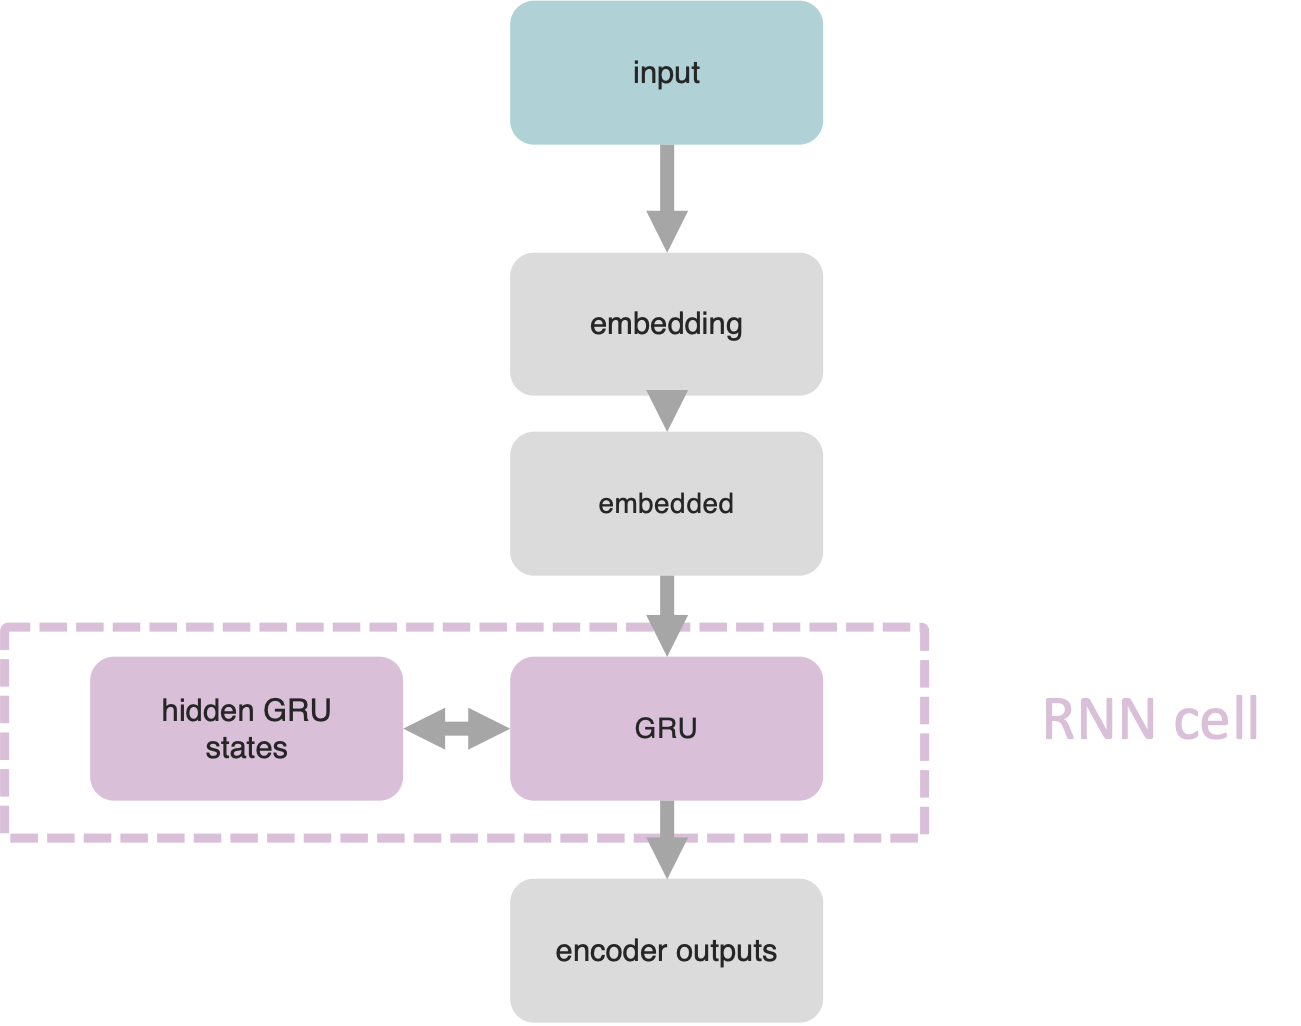

In [ ]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type='GRU', rnn_n_layers=1, batch_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.rnn_type = rnn_type
        self.rnn_n_layers = rnn_n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = getattr(nn, rnn_type)(self.hidden_size, self.hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        weights = torch.zeros(self.rnn_n_layers, self.batch_size, self.hidden_size, device=device)
        return (weights, weights) if self.rnn_type == 'LSTM' else weights



### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Attention Decoder


Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.
For this, we determine a set of attention weights which capture which part of the sentence is most important for the translation.
The attention weights will be multiplied by the encoder output vectors to create a weighted combination.
The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Specifically, this is done as follows:
1. Attention weights are caluclated with another feed-forward layer (`self.attn`) using the decoder's input and hidden state as inputs and appying a softmax to it.
   * Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.
1. The attention weights will be multiplied by the encoder output vectors to create a weighted combination (using `torch.bmm()`).
1. The encoder outputs weighted by the attention weights are combined with the decoder's embeddings and fed into another feed-forward layer (`self.attn_combine`).
1. ReLu is applied on the output of the attention module.

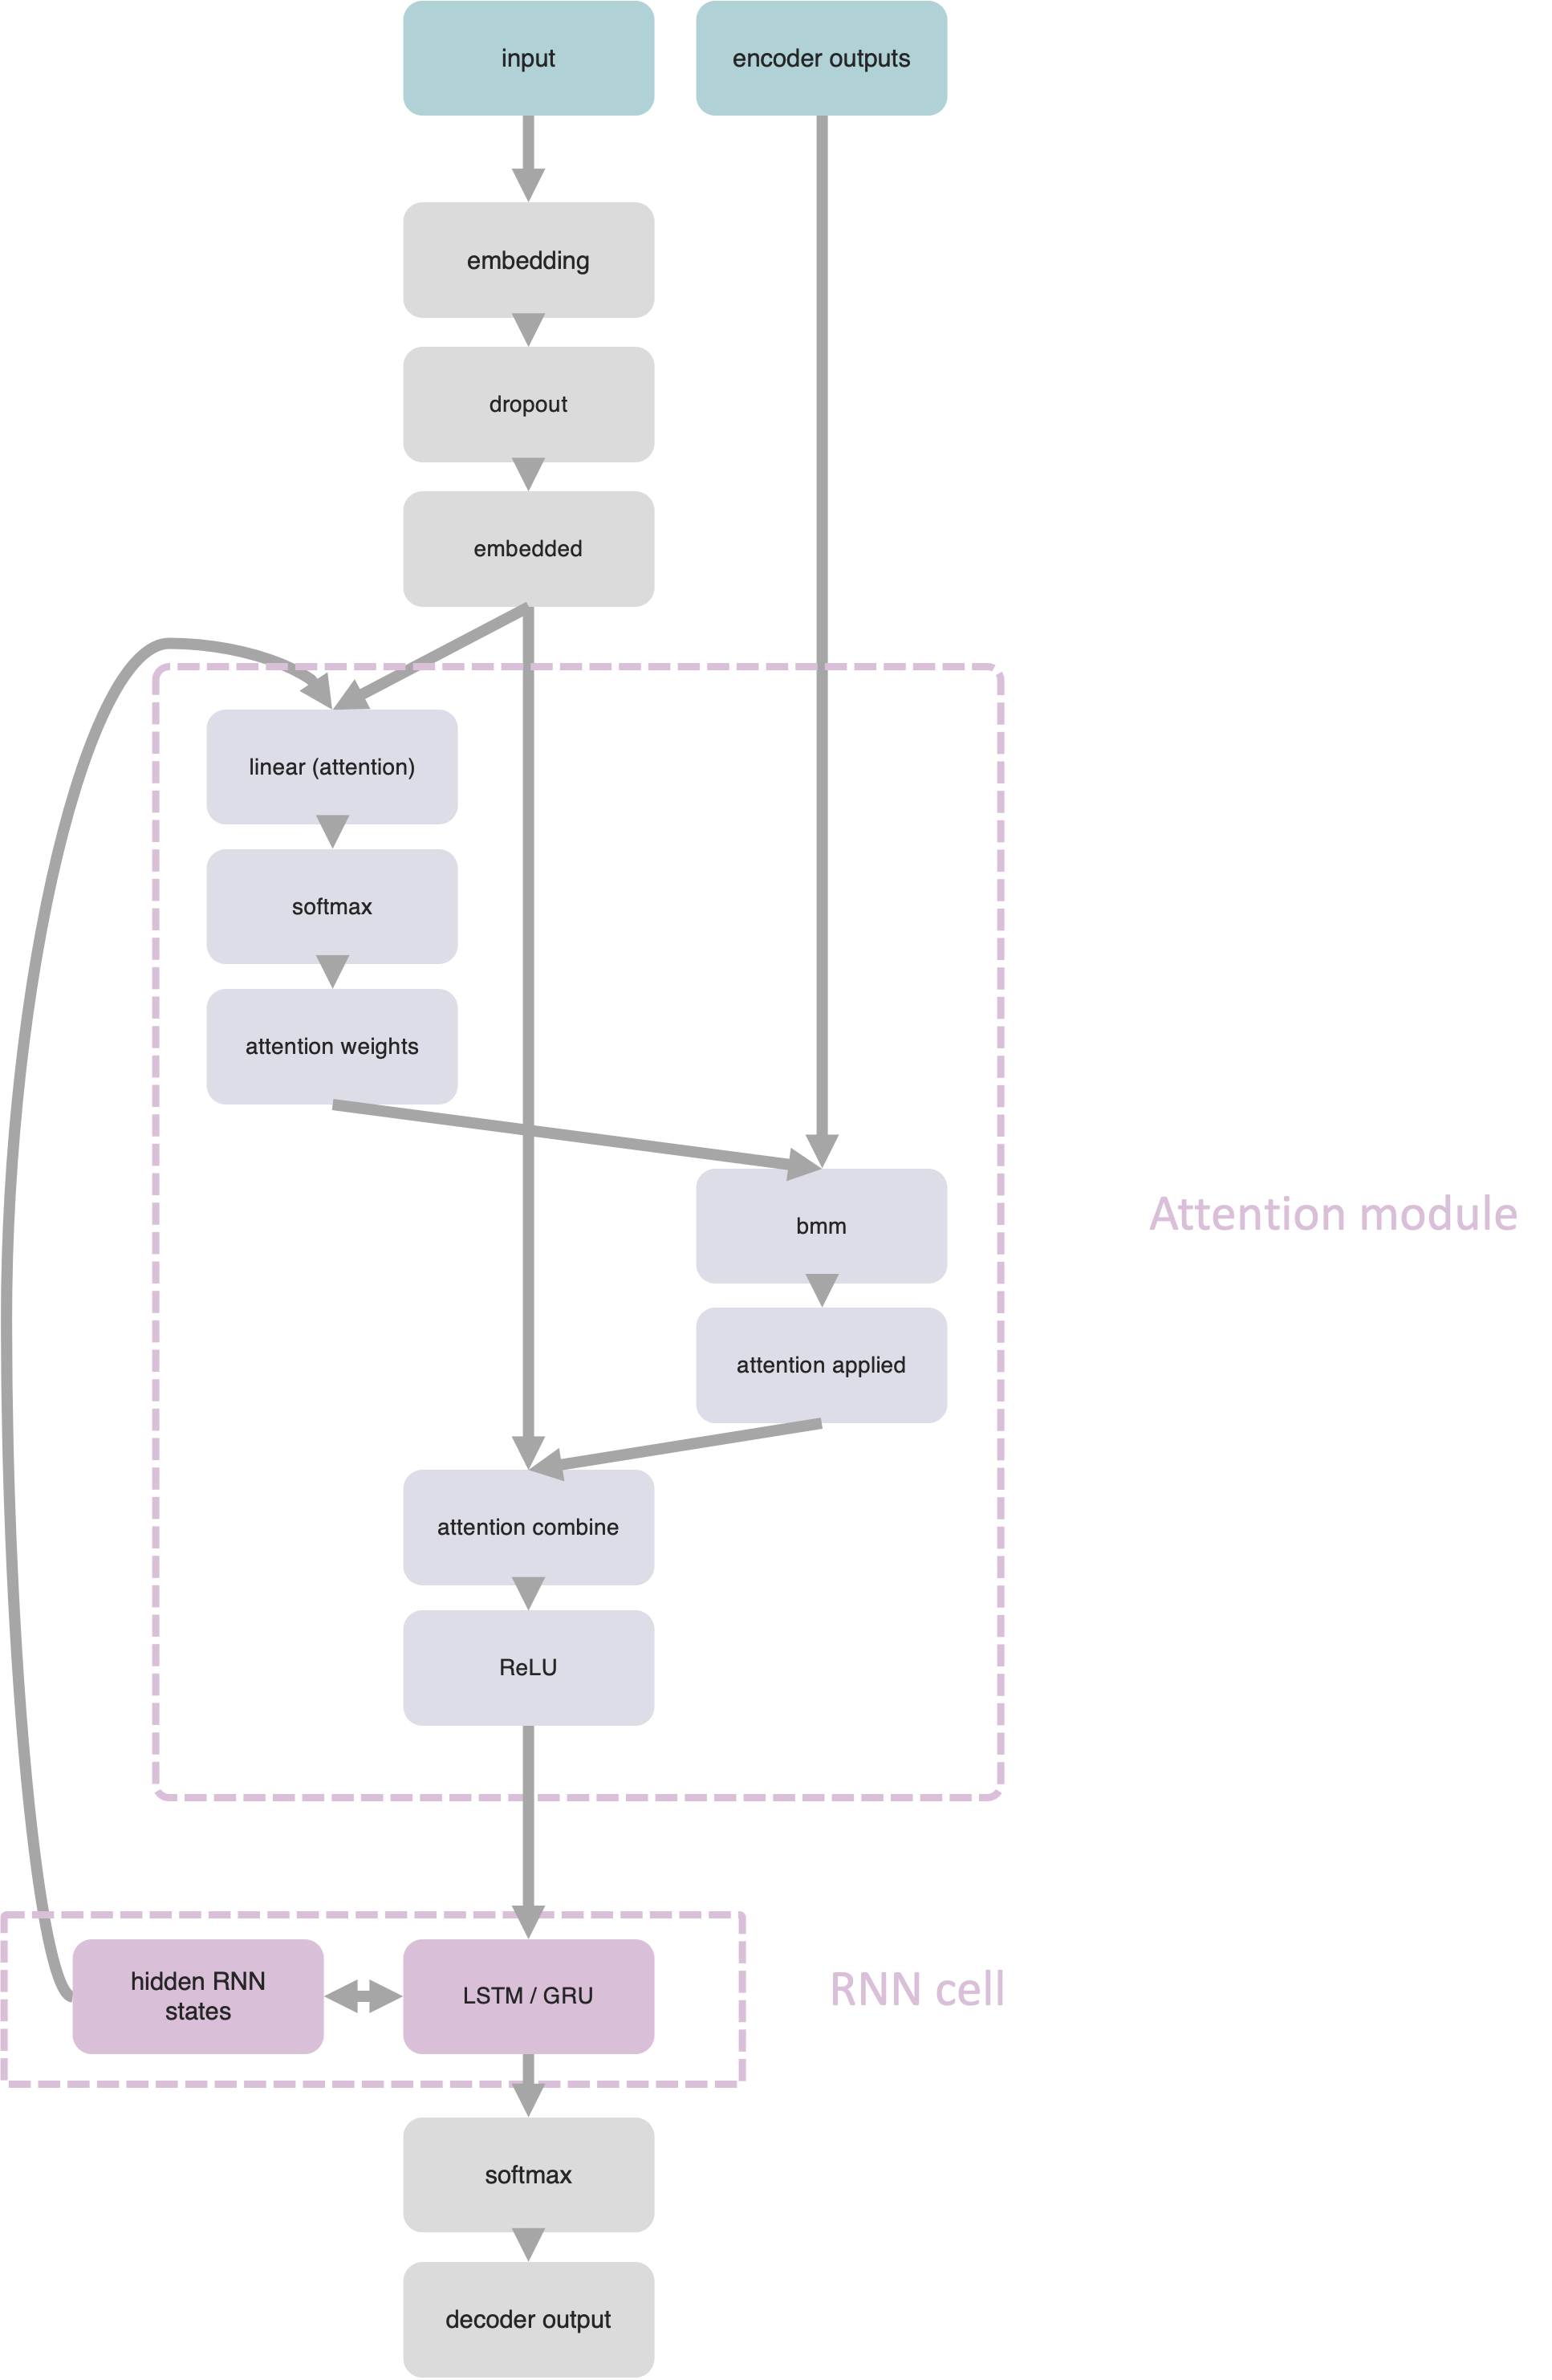

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size, max_length):

        super().__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)


    def forward(self, embedded, hidden, encoder_outputs):
        attn_weights = self.attn(torch.cat((embedded[0], hidden[0]), 1))
        attn_weights = F.softmax(attn_weights, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        return F.relu(output)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, rnn_type='GRU', rnn_n_layers=1, batch_size=1, max_length=MAX_WORDS+1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.rnn_type = rnn_type
        self.rnn_n_layers = rnn_n_layers
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attention = Attention(self.hidden_size, self.max_length)
        self.rnn = getattr(nn, self.rnn_type)(self.hidden_size, self.hidden_size, self.rnn_n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # c0 = self.init_hidden()
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        if self.rnn_type == 'LSTM':
            attn_hidden = hidden[0] # only hidden, not cell state
        else:
            attn_hidden = hidden # GRU has no cell state

        output = self.attention(embedded, attn_hidden, encoder_outputs)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output[0])
        output = F.log_softmax(output, dim=1)

        return output, hidden

    def init_hidden(self):
        weights = torch.zeros(self.rnn_n_layers, self.batch_size, self.hidden_size, device=device)
        return (weights, weights) if self.rnn_type == 'LSTM' else weights


## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_WORDS+1):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_WORDS+1):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        # decoder_hidden = (encoder_hidden, encoder_hidden)
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. When training from scratch after about 40 minutes on a MacBook CPU we'll get some
reasonable results.

To speed-up the training, we do not randomly initialize the weights, but reuse the weights from a pretrained model.

Note: If you run this notebook you can train, interrupt the kernel,
evaluate, and continue training later.




#### Pre-trained GRU seq2seq model

Load the state dict including the weights of a pre-trained model. If the initialization does not work, the architecture of your decoder is likely incorrect. Keep in mind that the two feed-forward layers of the Attention module have to be named `attn` and `attn_combine`.

In [ ]:
hidden_size = 256
encoder_file = os.path.join('data', 'pretrained_encoder.pth')
pretrained_encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='GRU').to(device)
pretrained_encoder.load_state_dict(torch.load(encoder_file))
pretrained_encoder.eval()

EncoderRNN(
  (embedding): Embedding(5511, 256)
  (rnn): GRU(256, 256)
)

In [ ]:
hidden_size = 256
decoder_file = os.path.join('data', 'pretrained_decoder.pth')
pretrained_attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', dropout_p=0.1).to(device)
pretrained_attn_decoder.load_state_dict(torch.load(decoder_file))
pretrained_attn_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(3485, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Attention(
    (attn): Linear(in_features=512, out_features=11, bias=True)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  )
  (rnn): GRU(256, 256)
  (out): Linear(in_features=256, out_features=3485, bias=True)
)

In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='GRU').to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', batch_size=1, dropout_p=0.1).to(device)


In [ ]:
trainIters(encoder, attn_decoder, 50000, print_every=100)

0m 6s (- 53m 42s) (100 0%) 4.7037
0m 11s (- 48m 29s) (200 0%) 3.6515
0m 16s (- 46m 7s) (300 0%) 3.7997
0m 21s (- 44m 51s) (400 0%) 3.3974
0m 26s (- 44m 27s) (500 1%) 3.5113
0m 32s (- 44m 27s) (600 1%) 3.5814
0m 37s (- 44m 12s) (700 1%) 3.5276
0m 43s (- 44m 24s) (800 1%) 3.6283
0m 48s (- 43m 58s) (900 1%) 3.2773
0m 53s (- 43m 35s) (1000 2%) 3.2457
0m 58s (- 43m 13s) (1100 2%) 3.2152
1m 3s (- 43m 17s) (1200 2%) 3.3806
1m 9s (- 43m 11s) (1300 2%) 3.2582
1m 14s (- 43m 16s) (1400 2%) 3.2726
1m 20s (- 43m 16s) (1500 3%) 3.2236
1m 25s (- 43m 4s) (1600 3%) 3.0601
1m 30s (- 42m 44s) (1700 3%) 2.9549
1m 35s (- 42m 37s) (1800 3%) 3.2302
1m 40s (- 42m 34s) (1900 3%) 2.9425
1m 46s (- 42m 30s) (2000 4%) 3.0330
1m 51s (- 42m 25s) (2100 4%) 3.0668
1m 57s (- 42m 25s) (2200 4%) 3.1434
2m 2s (- 42m 17s) (2300 4%) 2.9795
2m 7s (- 42m 14s) (2400 4%) 3.0263
2m 13s (- 42m 12s) (2500 5%) 3.1129
2m 18s (- 42m 5s) (2600 5%) 3.1980
2m 23s (- 41m 55s) (2700 5%) 2.8774
2m 29s (- 41m 52s) (2800 5%) 2.9041
2m 34s (-

KeyboardInterrupt: 

In [ ]:
encoder_file = os.path.join('data', 'pretrained_encoder.pth')
decoder_file = os.path.join('data', 'pretrained_decoder.pth')

# save state_dict() of best_model (not pickle full Python object)
torch.save(encoder.state_dict(), encoder_file)
torch.save(attn_decoder.state_dict(), decoder_file)

print('Model successfully saved to {}'.format(encoder_file))

Model successfully saved to data/pretrained_encoder.pth


In [ ]:
evaluateRandomly(pretrained_encoder, pretrained_attn_decoder)

> ich bin immer noch derselbe .
= i m still the same .
< i m still the same . <EOS>

> es stimmt mich traurig das zu horen .
= i am sad to hear it .
< i m very to to hear that . <EOS>

> sie spricht flie end englisch .
= she is a fluent speaker of english .
< she is a good at english . <EOS>

> ich freue mich wirklich auf morgen .
= i m really looking forward to tomorrow .
< i m really looking forward to tomorrow . <EOS>

> wir bekommen immer weniger schuler .
= we re getting fewer and fewer students .
< we re always having with each . <EOS>

> ich warte darauf dass tom wiederkommt .
= i m waiting for tom to return .
< i m waiting for tom tom will waiting . <EOS>

> du horst nicht zu oder ?
= you re not listening are you ?
< you aren t listening are you ? <EOS>

> sie ist allein zu nichts in der lage .
= she is incapable of doing anything alone .
< she is incapable of her anything . <EOS>

> ich freue mich darauf von ihm zu horen .
= i am looking forward to hearing from him .
< i m loo

#### LSTM decoder from scratch

To test the implementation of task 4, try to train the model with an LSTM cell.

There is no specific loss value to be achieved, just let the model train for 2-5min to demonstrate the training progress.

In [ ]:
hidden_size = 256
lstm_encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='LSTM').to(device)
lstm_attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='LSTM', dropout_p=0.1).to(device)

trainIters(lstm_encoder, lstm_attn_decoder, 5000, print_every=100)

0m 5s (- 4m 29s) (100 2%) 5.7754
0m 11s (- 4m 42s) (200 4%) 3.8518
0m 17s (- 4m 39s) (300 6%) 3.7727
0m 23s (- 4m 34s) (400 8%) 3.6457
0m 30s (- 4m 31s) (500 10%) 3.4173
0m 36s (- 4m 26s) (600 12%) 3.5501
0m 42s (- 4m 22s) (700 14%) 3.7154
0m 47s (- 4m 10s) (800 16%) 3.5860
0m 53s (- 4m 3s) (900 18%) 3.4022
0m 59s (- 3m 56s) (1000 20%) 3.3276
1m 4s (- 3m 48s) (1100 22%) 3.3238
1m 9s (- 3m 41s) (1200 24%) 3.4580
1m 15s (- 3m 34s) (1300 26%) 3.4780
1m 20s (- 3m 27s) (1400 28%) 3.2523
1m 25s (- 3m 20s) (1500 30%) 3.3453
1m 31s (- 3m 13s) (1600 32%) 3.2144
1m 36s (- 3m 7s) (1700 34%) 3.3181
1m 41s (- 3m 1s) (1800 36%) 3.2233
1m 47s (- 2m 55s) (1900 38%) 3.2581
1m 52s (- 2m 49s) (2000 40%) 3.1124
1m 58s (- 2m 43s) (2100 42%) 3.2407
2m 4s (- 2m 38s) (2200 44%) 3.0993
2m 10s (- 2m 33s) (2300 46%) 3.0685
2m 17s (- 2m 28s) (2400 48%) 3.1387
2m 23s (- 2m 23s) (2500 50%) 3.1474
2m 29s (- 2m 17s) (2600 52%) 3.1424
2m 34s (- 2m 11s) (2700 54%) 3.0495
2m 40s (- 2m 5s) (2800 56%) 3.1213
2m 47s (- 2m 

In [ ]:
encoder_file = os.path.join('data', 'lstm_pretrained_encoder.pth')
decoder_file = os.path.join('data', 'lstm_pretrained_decoder.pth')

# save state_dict() of best_model (not pickle full Python object)
torch.save(lstm_encoder.state_dict(), encoder_file)
torch.save(lstm_attn_decoder.state_dict(), decoder_file)

print('Model successfully saved to {}'.format(encoder_file))

## Self Attention

"What do BERT, RoBERTa, ALBERT, SpanBERT, DistilBERT, SesameBERT, SemBERT, SciBERT, BioBERT, MobileBERT, TinyBERT and CamemBERT all have in common?" It's not just “BERT” [[1]](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a).

Self-attention is one of the key ingredients of modern deep natural language processing architectures such as Transformers. The core concept behind self-attention is the scaled dot product attention. In their paper, “Attention Is All You Need,” [Vaswani et al. (2017)](https://arxiv.org/pdf/1706.03762.pdf) explain that the Transformer model relies solely on the use of self-attention, where the representation of a sequence is computed by relating different words in the same sequence [[2]](https://machinelearningmastery.com/the-transformer-attention-mechanism/). A good tutorial to get started with dot-product self-attention is: [[3]](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

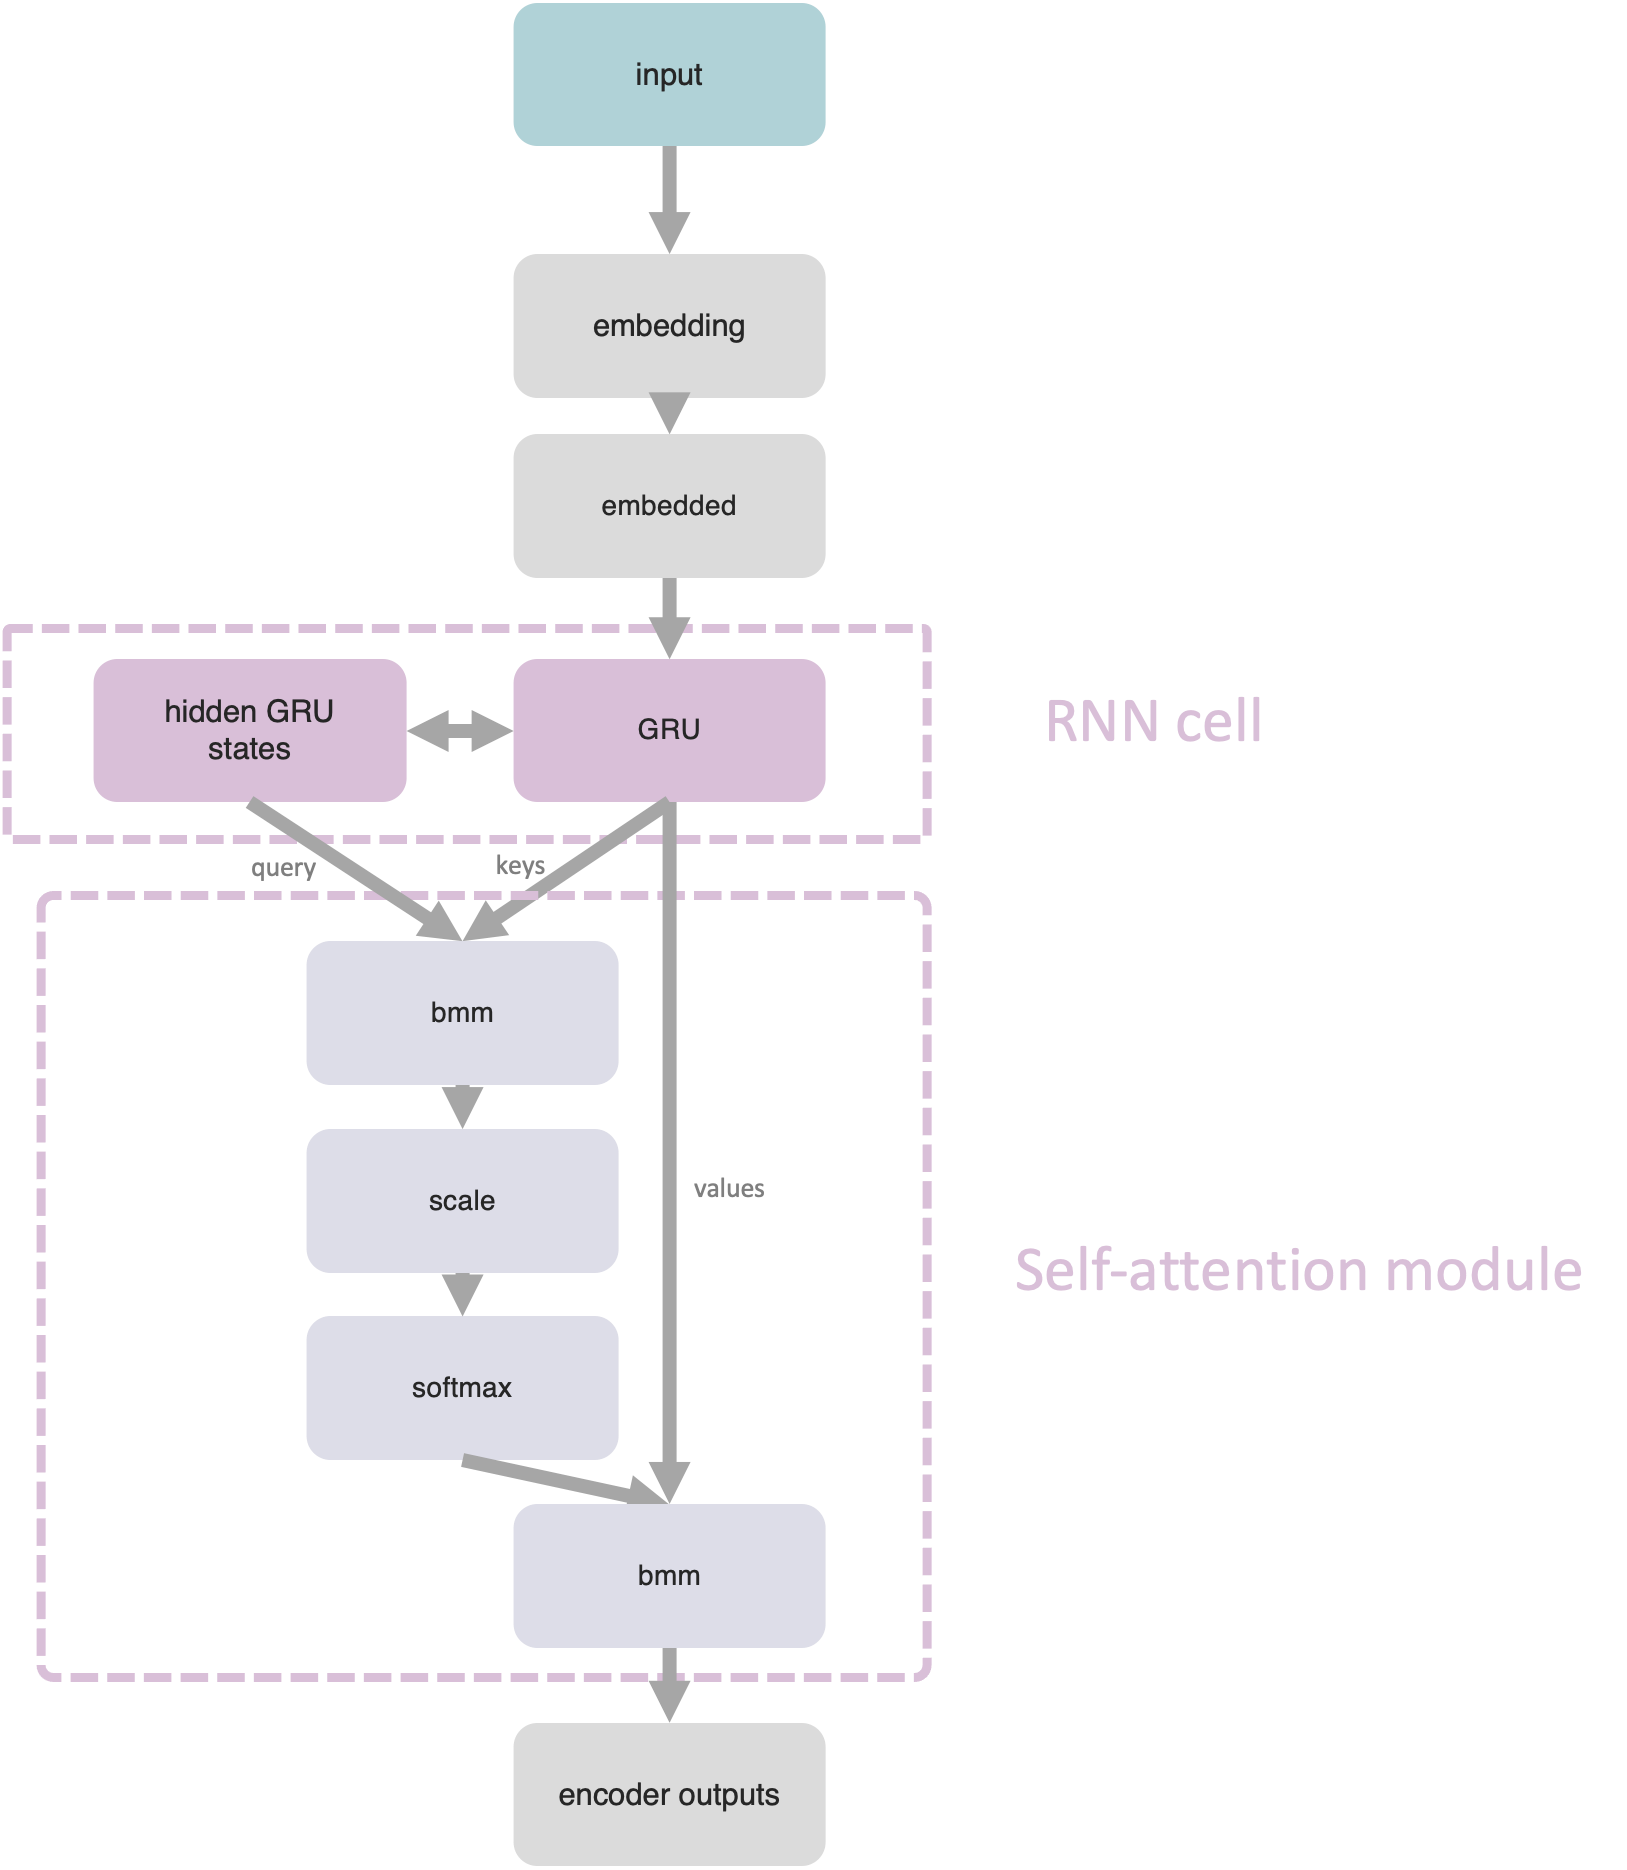

In [ ]:
"""
TODO: Task 5

Implement the SelfAttention's forward pass following the scaled dot-product attention pattern (https://arxiv.org/pdf/1706.03762.pdf).

Use the new encoder architecture and show the train progress (3-5 min) of the model on the translation task (see cell below).

Hint:
* Normalization is done with softmax and scaling with the given self.scale() function.
* The figure above depicts the desired encoder architecture incorporating self-attention.

The RNN cell's outputs are used as keys and values and the RNN cell's last hidden state as the query for the self attention module.
"""

class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size # corresponds to query dimension

    def forward(self, query, keys, values):

        # We assume query dimension == keys dim dimension (dot product attention)

        # Query = [BxQ]
        # Keys = [TxBxK]
        # Values = [TxBxV]
        # Outputs = [BxV]

        query = query.unsqueeze(1) # [BxQ] -> [Bx1xQ]
        keys = keys.transpose(0,1).transpose(1,2) # [TxBxK] -> [BxKxT]
        score = torch.bmm(query, keys) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
        score = self.scale(score) # scale
        score = F.softmax(score, dim=2) # normalize

        values = values.transpose(0,1) # [TxBxV] -> [BxTxV]
        attn_applied = torch.bmm(score, values).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]

        return attn_applied

    def scale(self, score):
        scale = 1. / math.sqrt(self.hidden_size)
        return torch.mul(score, scale)


class AttnEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type='GRU', batch_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn_type = rnn_type
        self.batch_size = batch_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = getattr(nn, rnn_type)(self.hidden_size, self.hidden_size)
        self.attention = SelfAttention()

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        last_hidden = hidden[-1]
        output = self.attention(last_hidden, output, output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

Test your self-attention implemention as follows:

In [ ]:
hidden_size = 256
attn_encoder = AttnEncoderRNN(input_lang.n_words, hidden_size, rnn_type='GRU').to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', dropout_p=0.1).to(device)

trainIters(attn_encoder, attn_decoder, 5000, print_every=100)

0m 7s (- 91m 31s) (100 0%) 4.5986
0m 12s (- 77m 54s) (200 0%) 3.8311
0m 17s (- 73m 57s) (300 0%) 3.6337
0m 23s (- 72m 16s) (400 0%) 3.5072
0m 28s (- 71m 52s) (500 0%) 3.5265
0m 34s (- 72m 4s) (600 0%) 3.3126
0m 40s (- 71m 43s) (700 0%) 3.4374
0m 46s (- 71m 23s) (800 1%) 3.3252
0m 51s (- 70m 49s) (900 1%) 3.1690
0m 57s (- 70m 48s) (1000 1%) 3.2199
1m 3s (- 71m 8s) (1100 1%) 3.4659
1m 9s (- 71m 14s) (1200 1%) 3.3148
1m 15s (- 71m 26s) (1300 1%) 3.4262
1m 21s (- 71m 41s) (1400 1%) 3.3451
1m 27s (- 71m 49s) (1500 2%) 3.3138
1m 33s (- 71m 45s) (1600 2%) 3.1849
1m 39s (- 71m 20s) (1700 2%) 3.2450
1m 44s (- 71m 1s) (1800 2%) 3.1804
1m 50s (- 70m 57s) (1900 2%) 3.2997
1m 56s (- 70m 35s) (2000 2%) 3.2223
2m 2s (- 70m 35s) (2100 2%) 3.1762
2m 8s (- 71m 1s) (2200 2%) 3.1936
2m 14s (- 70m 42s) (2300 3%) 3.1177
2m 19s (- 70m 29s) (2400 3%) 3.0162
2m 25s (- 70m 31s) (2500 3%) 3.0940
2m 31s (- 70m 28s) (2600 3%) 3.0864
2m 37s (- 70m 10s) (2700 3%) 3.0146
2m 43s (- 70m 10s) (2800 3%) 3.0659
2m 49s (- 

KeyboardInterrupt: 